In [1]:
import numpy as np

from stable_baselines3.common.env_checker import check_env
from hem.HEM_v0 import aec_env, parallel_env, sa_env, gym_env
import yaml
from hem.env.utils import Renderer
from pettingzoo.test import api_test, parallel_api_test

import supersuit as ss

In [2]:
config_path = 'hem/env/config_env.yaml'
env_config = yaml.safe_load(open(config_path, 'r', encoding='utf-8'))

env_attr = {
    'random_episode_split': False,
    'rolling_episode_split': False,
    'data_start_end': (0, 122 * 24 * 60),  # 数据集中，一共6，7，8，9月，122天，1分钟一个数据点
    'episode_time_steps': int(24 * 60 / env_config['MINUTES_PER_TIME_STEP']),  # one day, 24 hours
    'mode': 'train',
    'random_seed': 1,
    'noise_strength': 0,
    'config_path': config_path,
    'render_mode': 'None',
}

# Testing gym_env

Make env: mode: train, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
Episode Time: (864, 1151)
KPIs:
electrical_consumption_sum: 21.70
electrical_cost_sum: 98.90
discomfort_proportion: 0.85
discomfort_cold_proportion: 0.57
discomfort_hot_proportion: 0.28
BESS_electrical_consumption_contribution: 21.70 / 24.59, 0.12
BESS_electrical_cost_contribution: 98.90 / 105.84, 0.07
AC_control: 145 / 288, 0.50
BESS_control: 143 / 288, 0.50
washer_control: 131 / 288, 0.45
AC_reward: -15722.19
BESS_reward: 98.51
washer_reward: 155.92


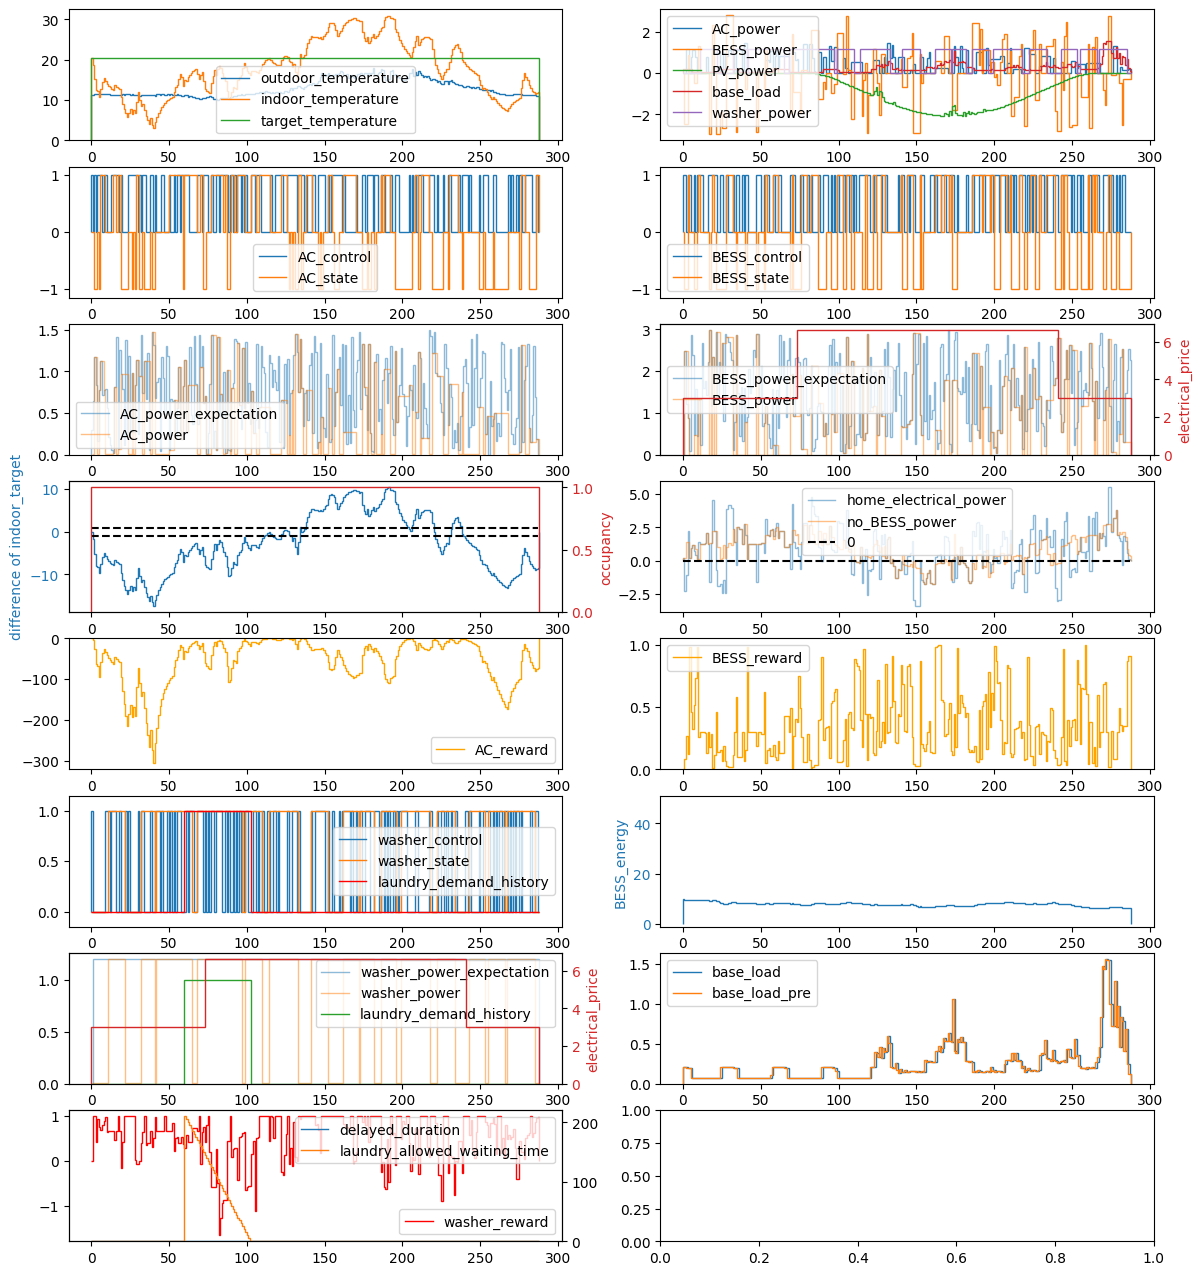

(36,) (16,)
Episode Time: (1152, 1439)
KPIs:
electrical_consumption_sum: 23.11
electrical_cost_sum: 115.12
discomfort_proportion: 0.90
discomfort_cold_proportion: 0.90
discomfort_hot_proportion: 0.00
BESS_electrical_consumption_contribution: 23.11 / 27.79, 0.17
BESS_electrical_cost_contribution: 115.12 / 129.39, 0.11
AC_control: 150 / 288, 0.52
BESS_control: 151 / 288, 0.52
washer_control: 145 / 288, 0.50
AC_reward: -15011.18
BESS_reward: 90.21
washer_reward: 96.29


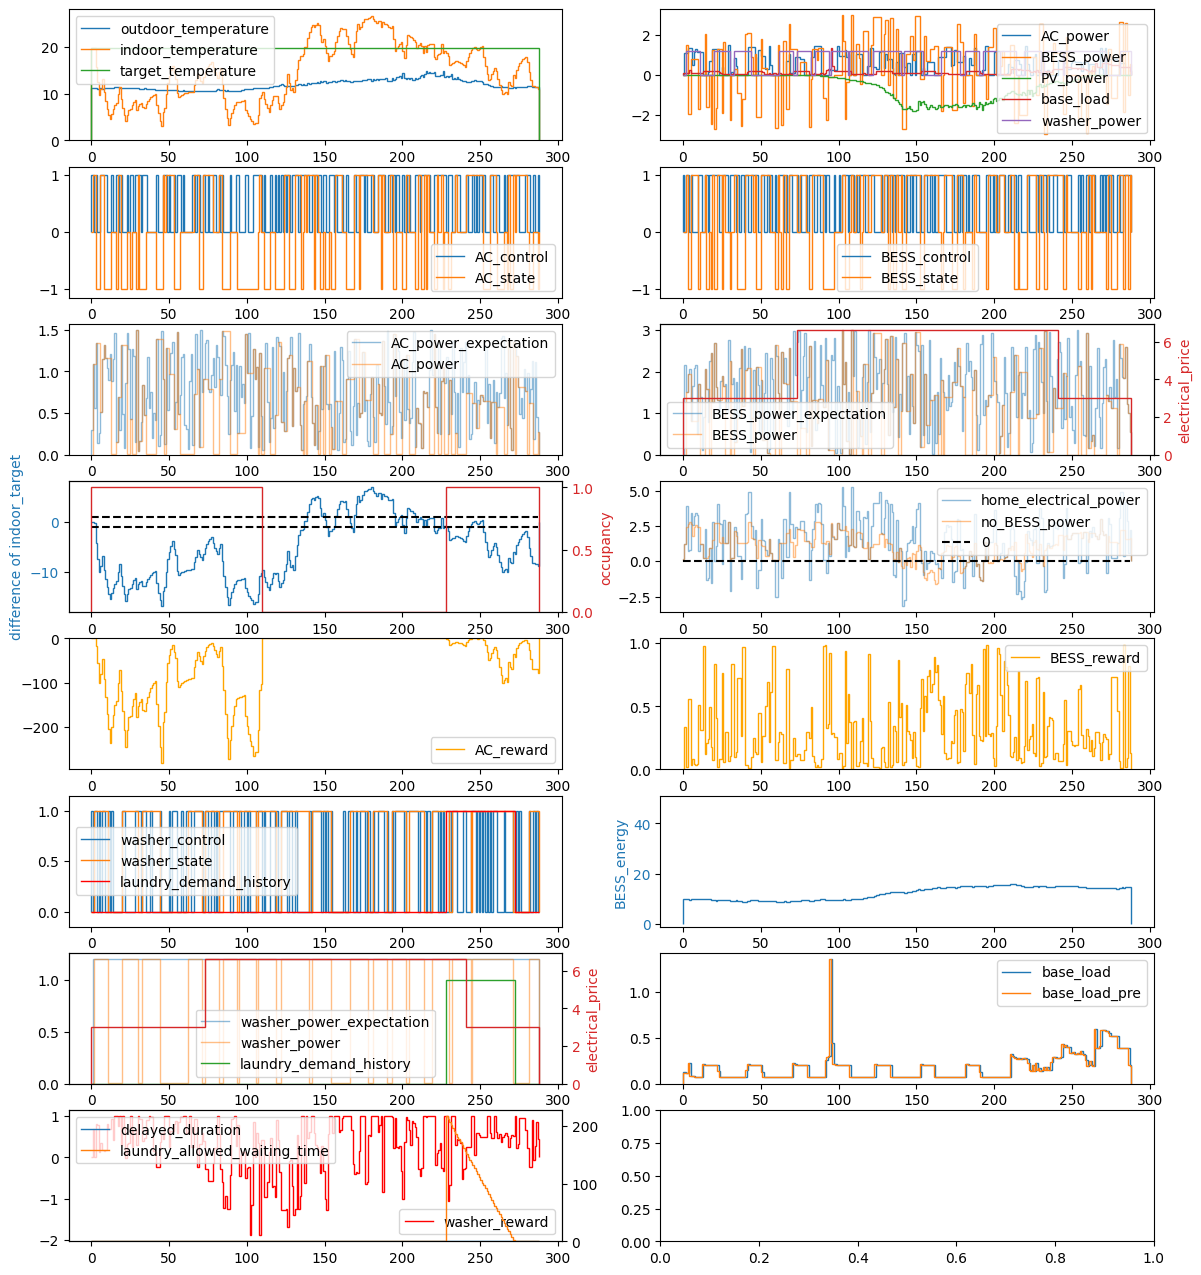

(36,) (16,)


In [3]:
env = gym_env(**env_attr)
check_env(env, warn=True)

renderer = Renderer(env=env.unwrapped, render_mode='episode')

for e in range(2):
    observation = env.reset()
    done = False
    while not done:
        actions = env.action_space.sample()
        observation, reward, termination, truncation, infos = env.step(actions)
        done = termination or truncation
        renderer.collect()
    renderer.render()
    print(observation.shape, actions.shape)
env.close()

In [4]:
env.metadata['name']

'RawGymEnv_for_HEM'

# Testing gym_vec_env

In [5]:
env = gym_env(**env_attr)
num_envs = 4
env = ss.stable_baselines3_vec_env_v0(env, num_envs=num_envs)

for e in range(2):
    observations = env.reset()
    dones = [False]
    while not any(dones):
        actions = env.action_space.sample()
        actions = np.array([actions] * num_envs)
        observations, rewards, dones, infos = env.step(actions)
    print(observation.shape, actions.shape)
env.close()

Make env: mode: train, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
(36,) (4, 16)
(36,) (4, 16)


# Testing aec_env

Make env: mode: train, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
Starting API test
Passed API test
Episode Time: (2016, 2303)
KPIs:
electrical_consumption_sum: 9.95
electrical_cost_sum: 37.77
discomfort_proportion: 0.88
discomfort_cold_proportion: 0.82
discomfort_hot_proportion: 0.06
BESS_electrical_consumption_contribution: 9.95 / 17.33, 0.43
BESS_electrical_cost_contribution: 37.77 / 75.30, 0.50
AC_control: 239 / 290, 0.82
BESS_control: 240 / 290, 0.83
washer_control: 240 / 290, 0.83
AC_reward: -951.09
BESS_reward: 43.73
washer_reward: 70.36


/opt/homebrew/anaconda3/envs/tianshou/lib/python3.11/site-packages/pettingzoo/test/api_test.py:266: UserWarning: We recommend agents to be named in the format <descriptor>_<number>, like "player_0"
  warnings.warn(


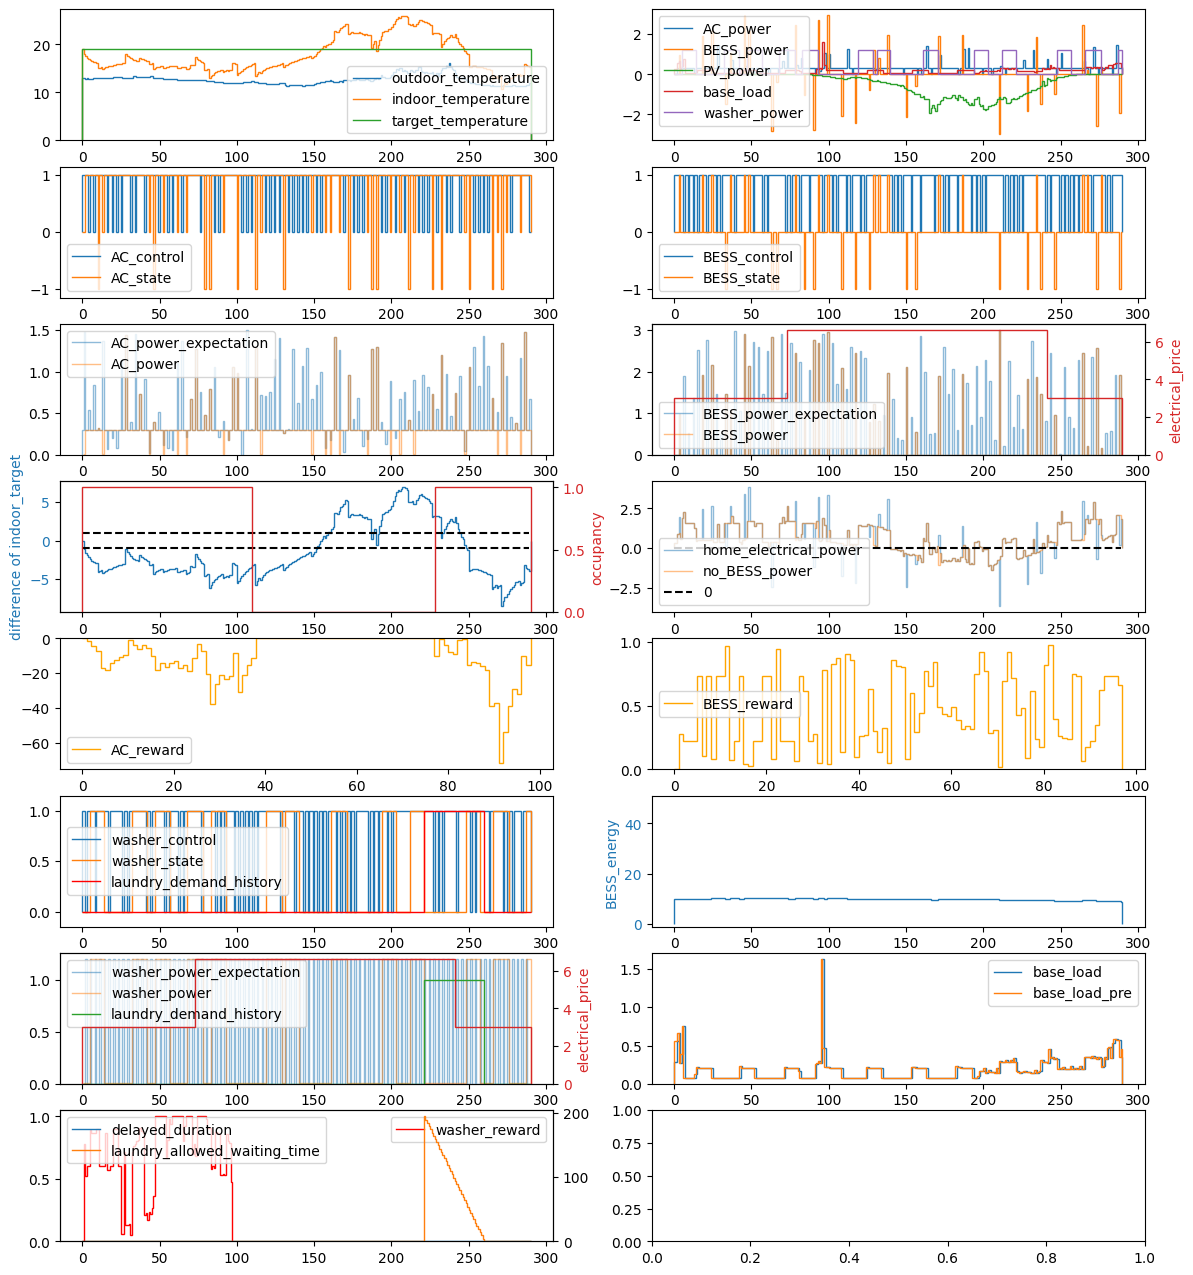

Episode Time: (2304, 2591)
KPIs:
electrical_consumption_sum: 9.22
electrical_cost_sum: 25.70
discomfort_proportion: 0.86
discomfort_cold_proportion: 0.56
discomfort_hot_proportion: 0.31
BESS_electrical_consumption_contribution: 9.22 / 17.26, 0.47
BESS_electrical_cost_contribution: 25.70 / 66.56, 0.61
AC_control: 244 / 290, 0.84
BESS_control: 236 / 290, 0.81
washer_control: 241 / 290, 0.83
AC_reward: -4327.01
BESS_reward: 39.05
washer_reward: 72.77


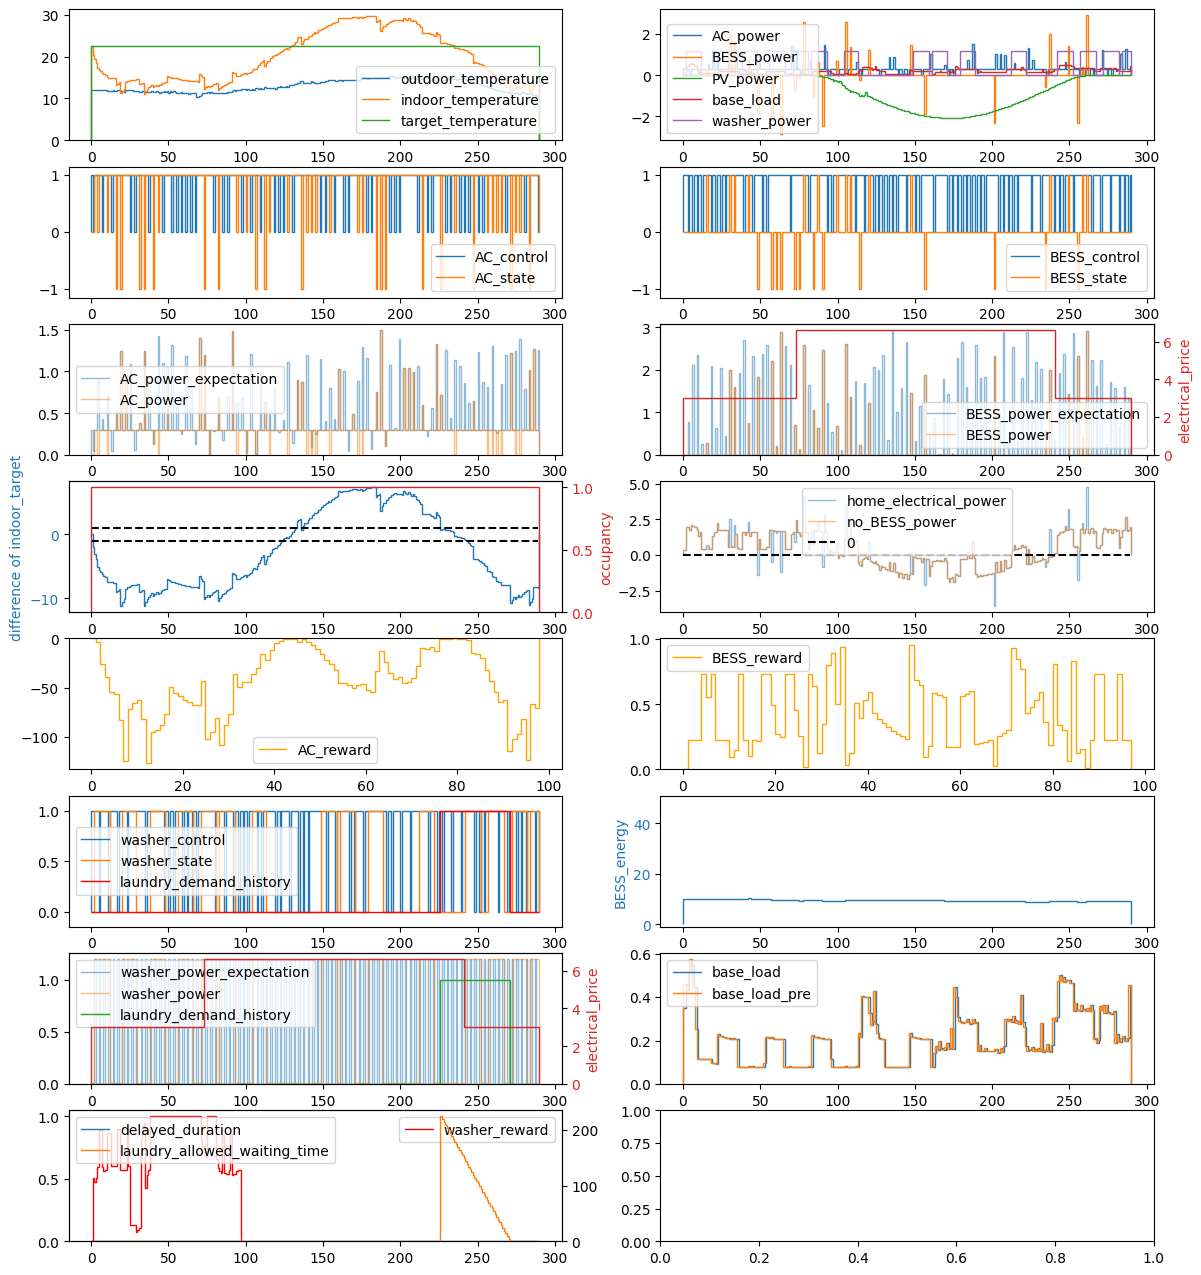

Episode Time: (2592, 2879)
KPIs:
electrical_consumption_sum: 6.83
electrical_cost_sum: 17.26
discomfort_proportion: 0.90
discomfort_cold_proportion: 0.62
discomfort_hot_proportion: 0.28
BESS_electrical_consumption_contribution: 6.83 / 15.37, 0.56
BESS_electrical_cost_contribution: 17.26 / 59.24, 0.71
AC_control: 235 / 290, 0.81
BESS_control: 236 / 290, 0.81
washer_control: 229 / 290, 0.79
AC_reward: -5668.87
BESS_reward: 44.78
washer_reward: 75.01


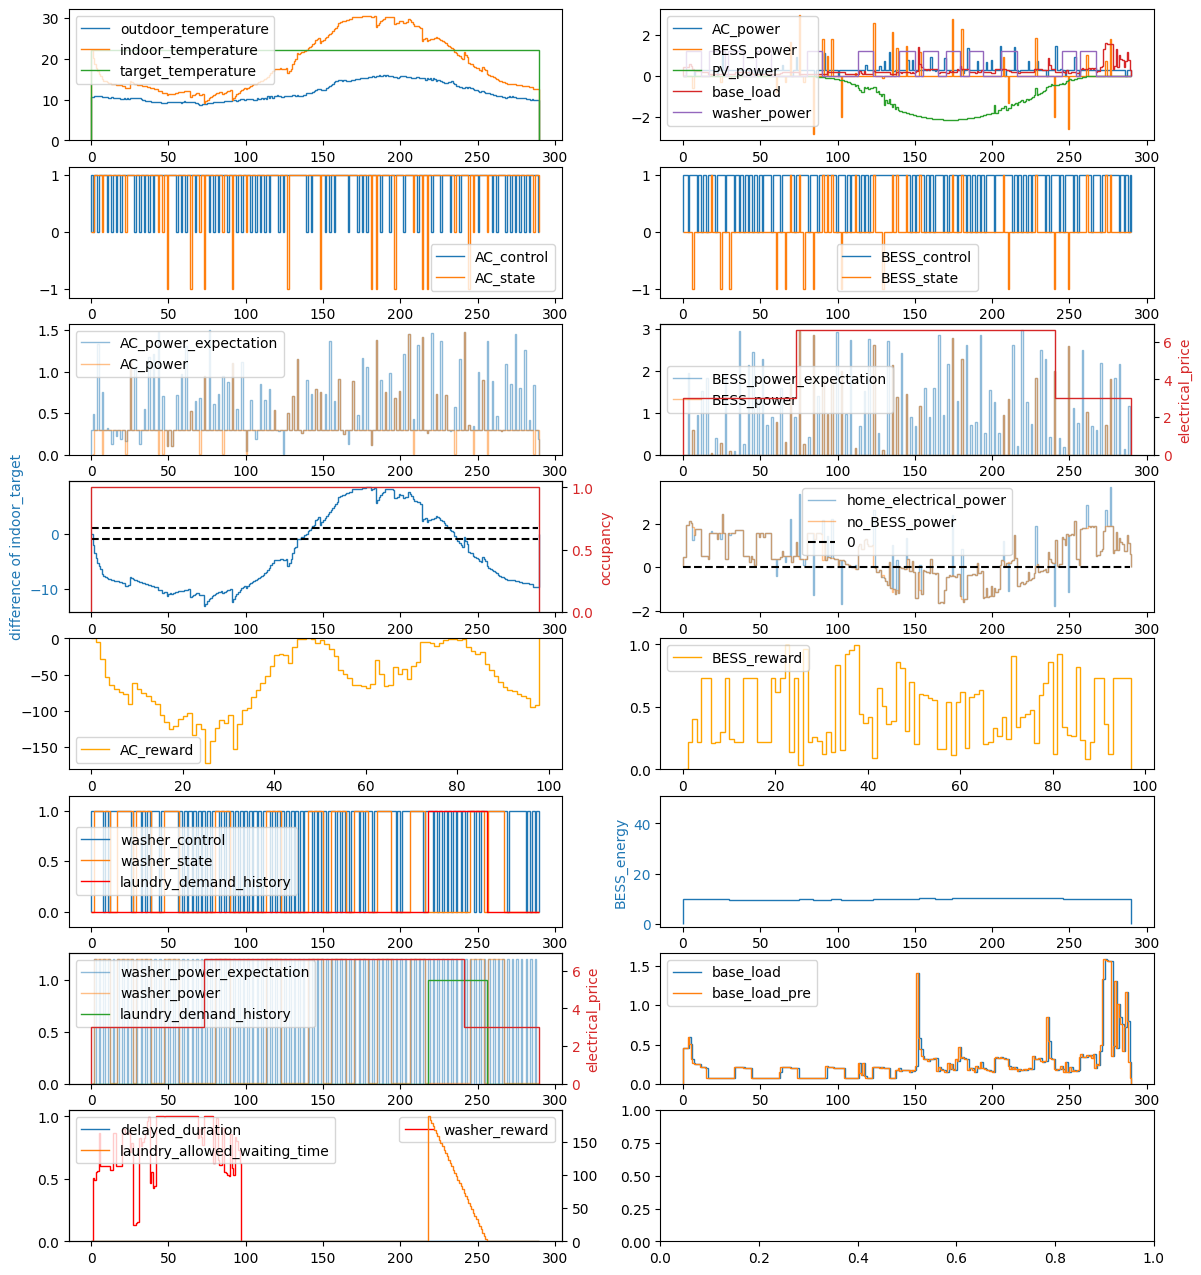

In [6]:
env = aec_env(**env_attr)
api_test(env, num_cycles=50)

renderer = Renderer(env=env.unwrapped, render_mode='episode')

for e in range(3):
    env.reset()
    for agent in env.agent_iter(max_iter=1e5):
        observation, reward, termination, truncation, infos = env.last()
        if termination or truncation:
            action = None
            break
        else:
            action = env.action_space(agent).sample()
        env.step(action)
        renderer.collect()
    renderer.render()
env.close()

# Testing parallel_env

Make env: mode: train, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
Passed Parallel API test
Episode Time: (864, 1151)
KPIs:
electrical_consumption_sum: 21.47
electrical_cost_sum: 92.09
discomfort_proportion: 0.92
discomfort_cold_proportion: 0.64
discomfort_hot_proportion: 0.28
BESS_electrical_consumption_contribution: 21.47 / 24.56, 0.13
BESS_electrical_cost_contribution: 92.09 / 102.81, 0.10
AC_control: 144 / 288, 0.50
BESS_control: 151 / 288, 0.52
washer_control: 153 / 288, 0.53
AC_reward: -22982.62
BESS_reward: 100.55
washer_reward: 164.54


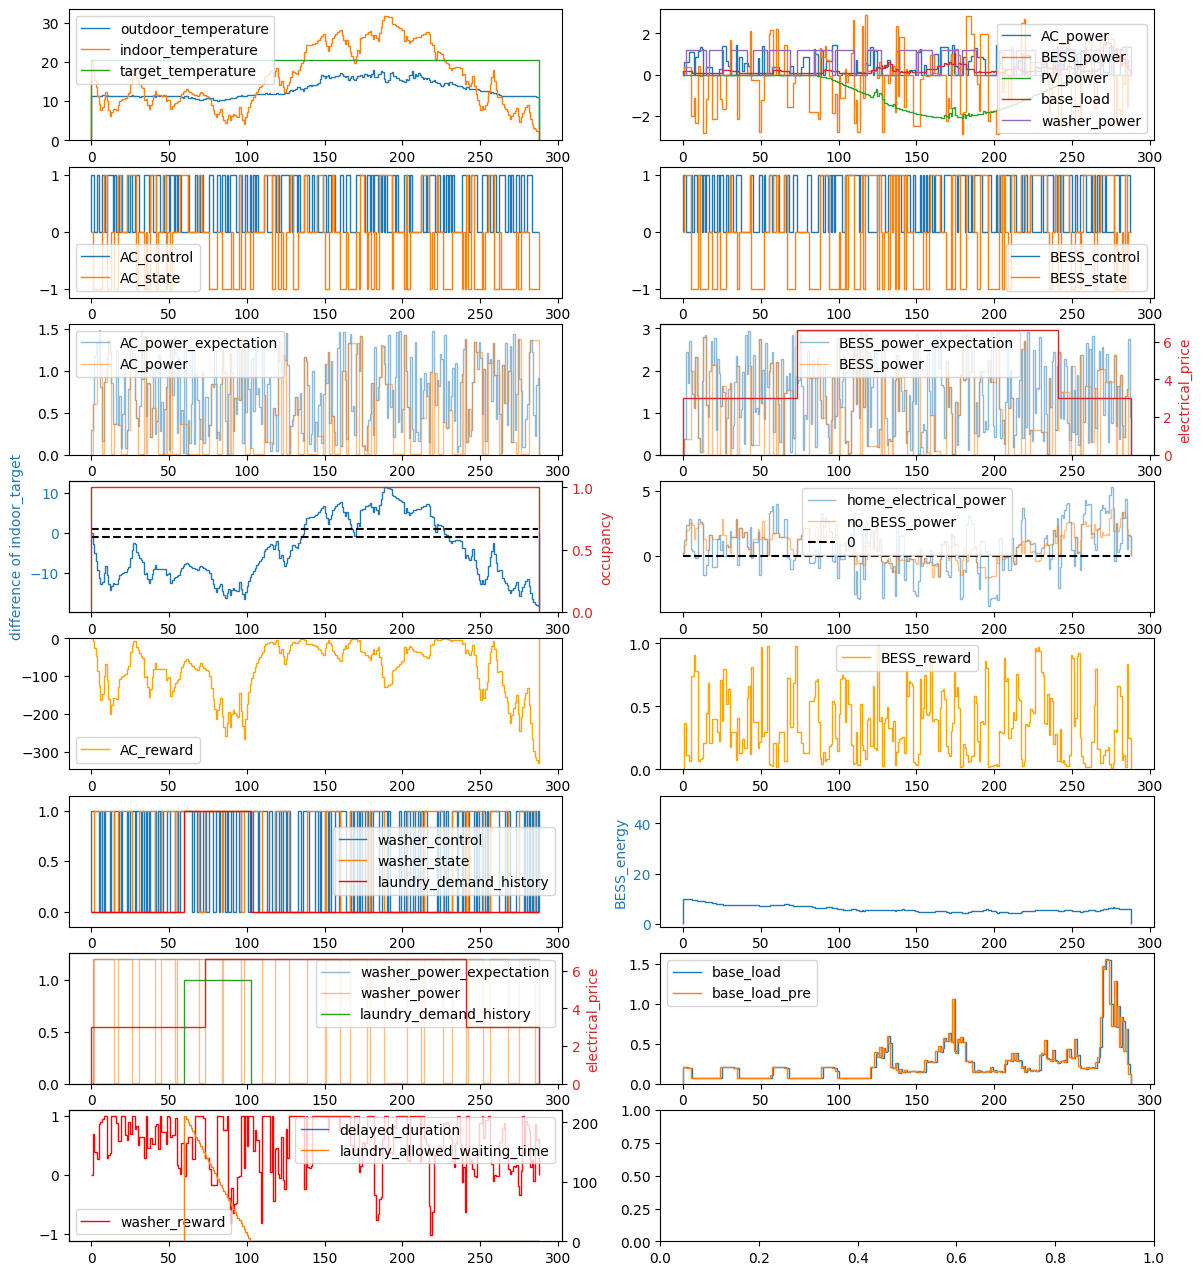

Episode Time: (1152, 1439)
KPIs:
electrical_consumption_sum: 22.39
electrical_cost_sum: 98.78
discomfort_proportion: 0.99
discomfort_cold_proportion: 0.99
discomfort_hot_proportion: 0.00
BESS_electrical_consumption_contribution: 22.39 / 26.19, 0.15
BESS_electrical_cost_contribution: 98.78 / 115.84, 0.15
AC_control: 151 / 288, 0.52
BESS_control: 159 / 288, 0.55
washer_control: 140 / 288, 0.49
AC_reward: -14662.92
BESS_reward: 101.00
washer_reward: 157.32


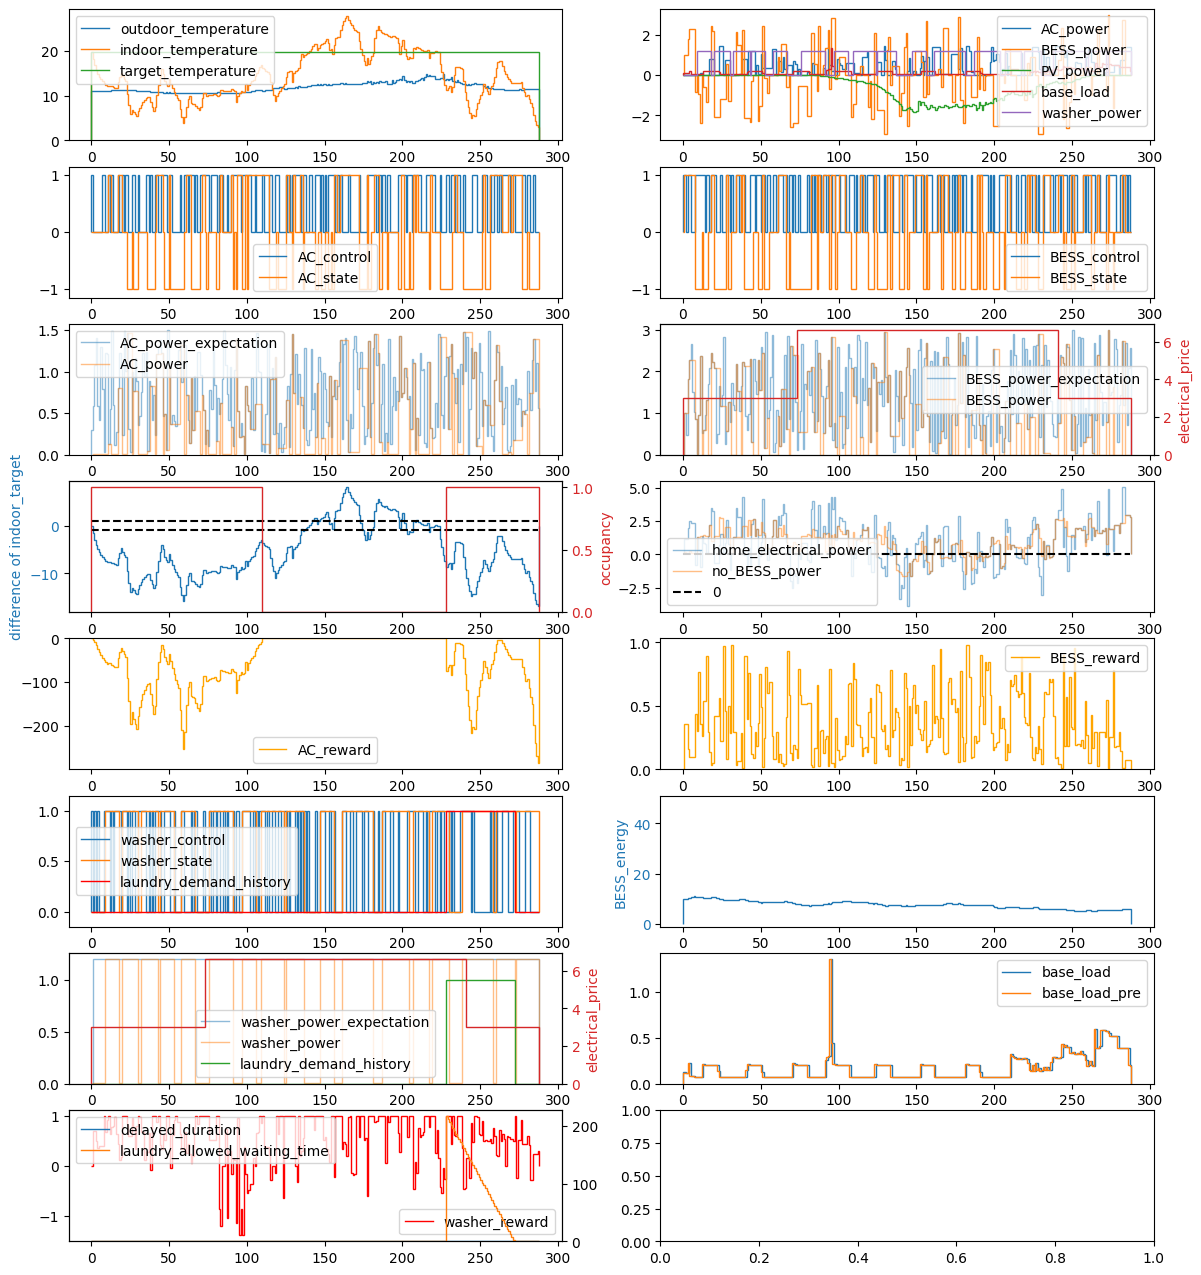

Episode Time: (1440, 1727)
KPIs:
electrical_consumption_sum: 23.12
electrical_cost_sum: 106.35
discomfort_proportion: 0.90
discomfort_cold_proportion: 0.86
discomfort_hot_proportion: 0.04
BESS_electrical_consumption_contribution: 23.12 / 26.42, 0.12
BESS_electrical_cost_contribution: 106.35 / 114.44, 0.07
AC_control: 137 / 288, 0.48
BESS_control: 139 / 288, 0.48
washer_control: 148 / 288, 0.51
AC_reward: -14231.75
BESS_reward: 98.62
washer_reward: 127.76


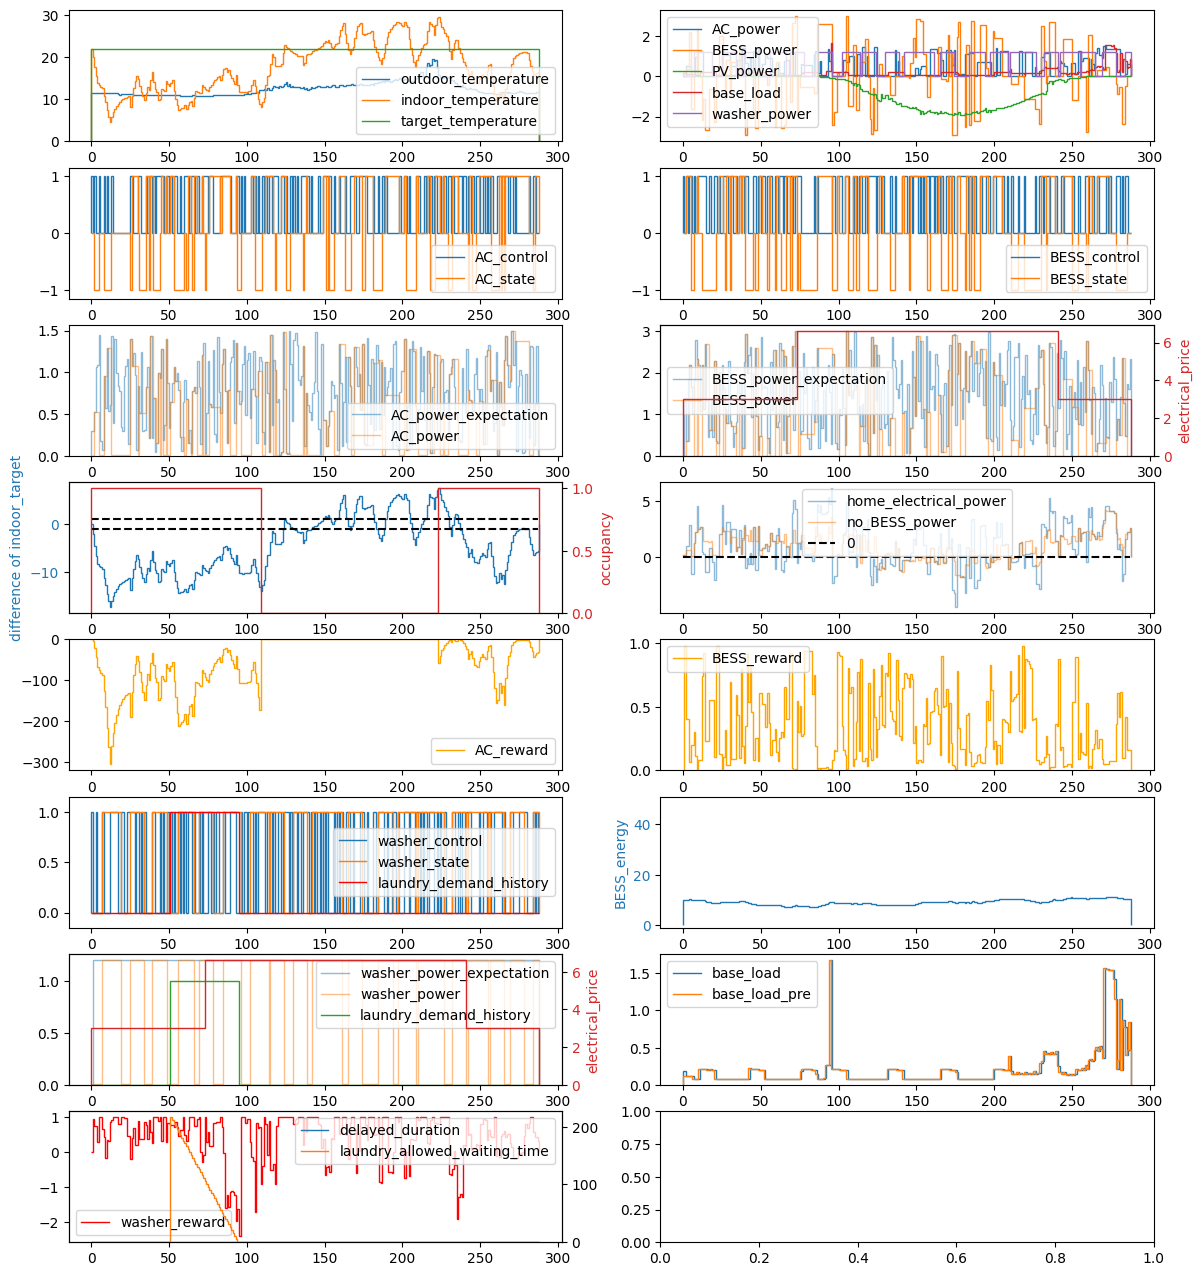

Episode Time: (1728, 2015)
KPIs:
electrical_consumption_sum: 23.82
electrical_cost_sum: 101.78
discomfort_proportion: 0.90
discomfort_cold_proportion: 0.90
discomfort_hot_proportion: 0.00
BESS_electrical_consumption_contribution: 23.82 / 26.20, 0.09
BESS_electrical_cost_contribution: 101.78 / 108.05, 0.06
AC_control: 145 / 288, 0.50
BESS_control: 137 / 288, 0.48
washer_control: 143 / 288, 0.50
AC_reward: -9204.45
BESS_reward: 100.36
washer_reward: 157.61


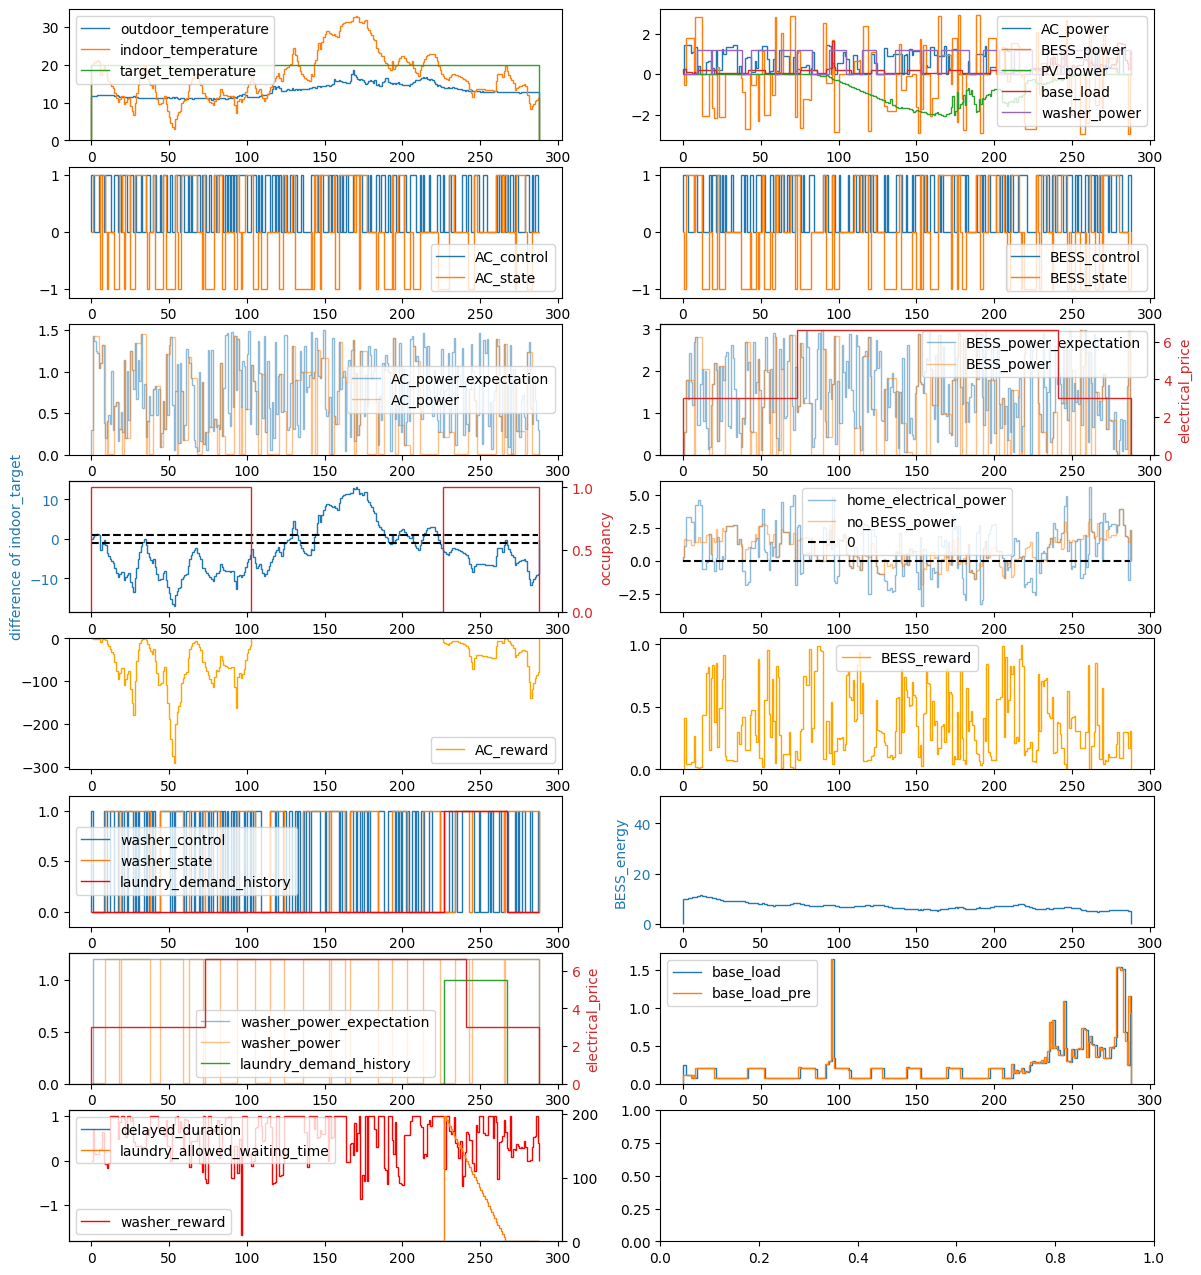

In [7]:
env = parallel_env(**env_attr)
parallel_api_test(env, num_cycles=50)

renderer = Renderer(env=env.unwrapped, render_mode='episode')

for e in range(4):
    observation, infos = env.reset()
    terminations = {agent: False for agent in env.agents}
    truncations = {agent: False for agent in env.agents}
    while not any(terminations.values()) and not any(truncations.values()):
        actions = {agent: env.action_space(agent).sample() for agent in env.agents}
        observation, rewards, terminations, truncations, infos = env.step(actions)
        renderer.collect()
    renderer.render()
env.close()

# Testing sa_env

Make env: mode: train, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
Passed Parallel API test
Episode Time: (864, 1151)
KPIs:
electrical_consumption_sum: 11.76
electrical_cost_sum: 40.93
discomfort_proportion: 0.87
discomfort_cold_proportion: 0.51
discomfort_hot_proportion: 0.36
BESS_electrical_consumption_contribution: 11.76 / 20.64, 0.43
BESS_electrical_cost_contribution: 40.93 / 86.30, 0.53
AC_control: 288 / 288, 1.00
BESS_control: 288 / 288, 1.00
washer_control: 155 / 288, 0.54
AC_reward: 0.00
BESS_reward: 0.00
washer_reward: 200.76


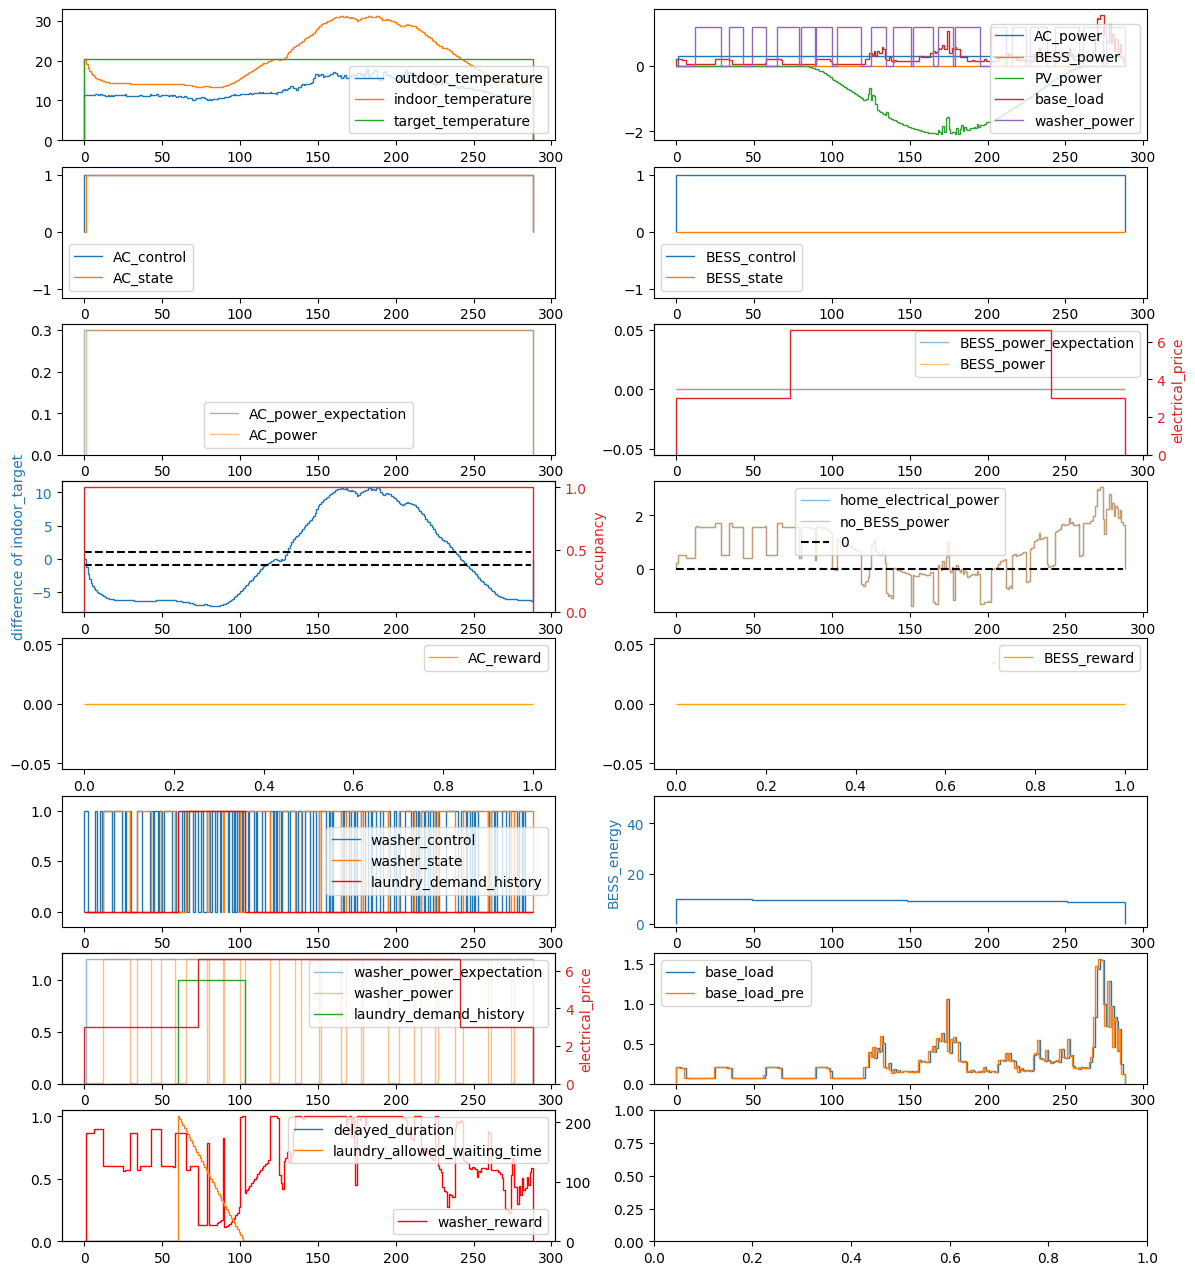

Episode Time: (1152, 1439)
KPIs:
electrical_consumption_sum: 12.32
electrical_cost_sum: 47.38
discomfort_proportion: 0.85
discomfort_cold_proportion: 0.85
discomfort_hot_proportion: 0.01
BESS_electrical_consumption_contribution: 12.32 / 21.20, 0.42
BESS_electrical_cost_contribution: 47.38 / 92.75, 0.49
AC_control: 288 / 288, 1.00
BESS_control: 288 / 288, 1.00
washer_control: 132 / 288, 0.46
AC_reward: 0.00
BESS_reward: 0.00
washer_reward: 194.29


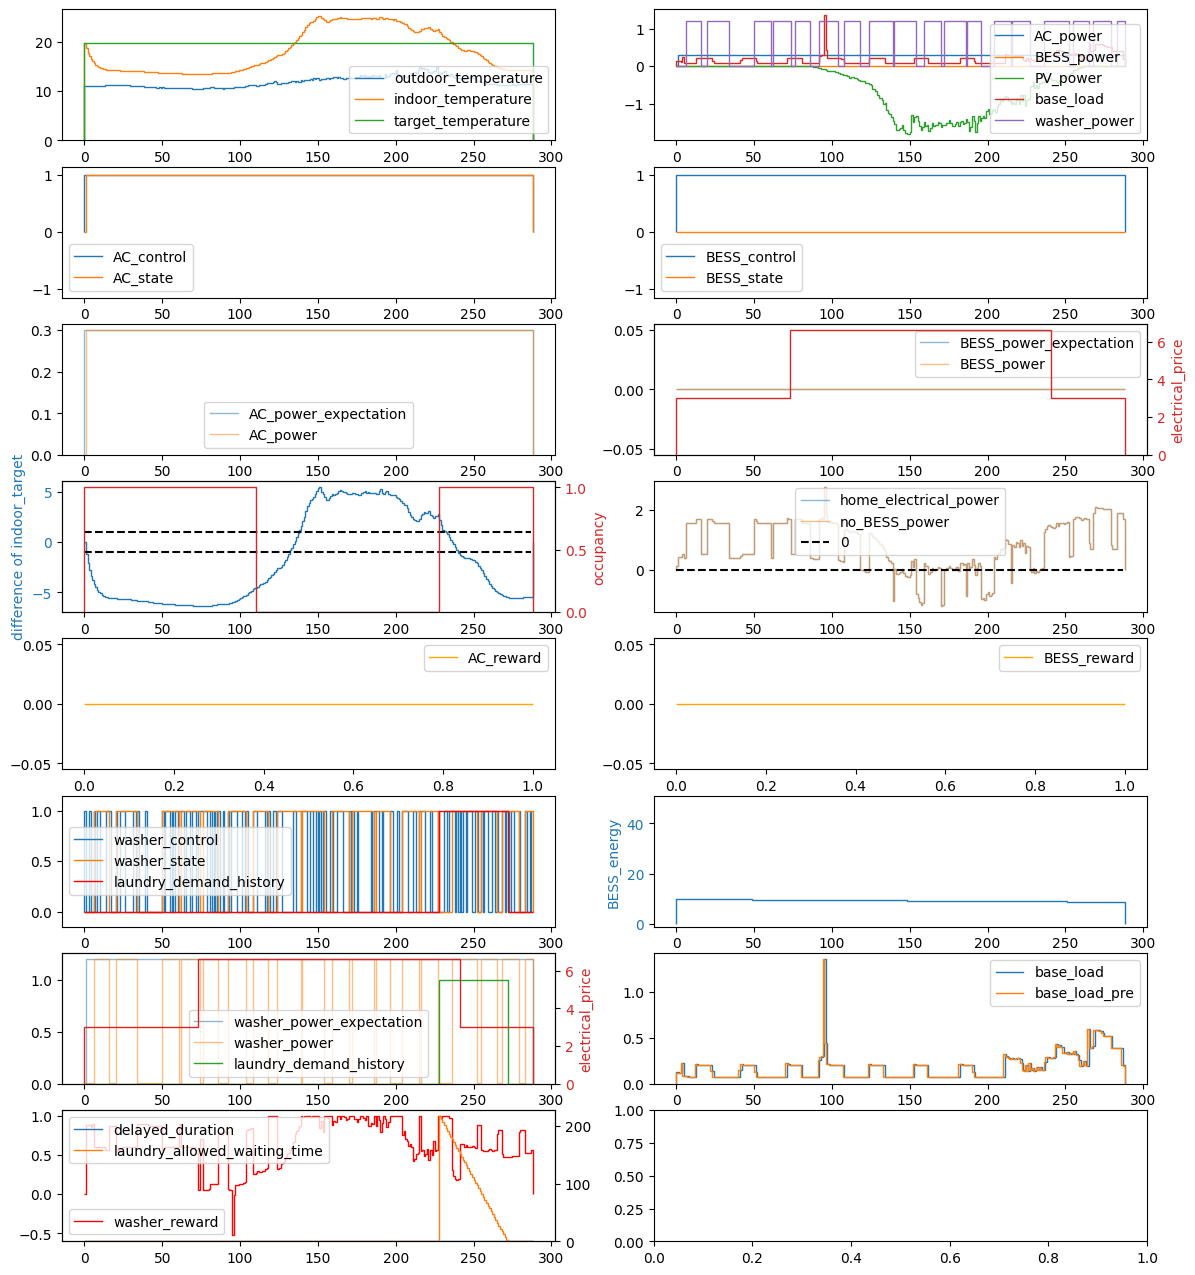

Episode Time: (1440, 1727)
KPIs:
electrical_consumption_sum: 13.11
electrical_cost_sum: 47.36
discomfort_proportion: 0.95
discomfort_cold_proportion: 0.90
discomfort_hot_proportion: 0.05
BESS_electrical_consumption_contribution: 13.11 / 21.98, 0.40
BESS_electrical_cost_contribution: 47.36 / 92.73, 0.49
AC_control: 288 / 288, 1.00
BESS_control: 288 / 288, 1.00
washer_control: 137 / 288, 0.48
AC_reward: 0.00
BESS_reward: 0.00
washer_reward: 194.32


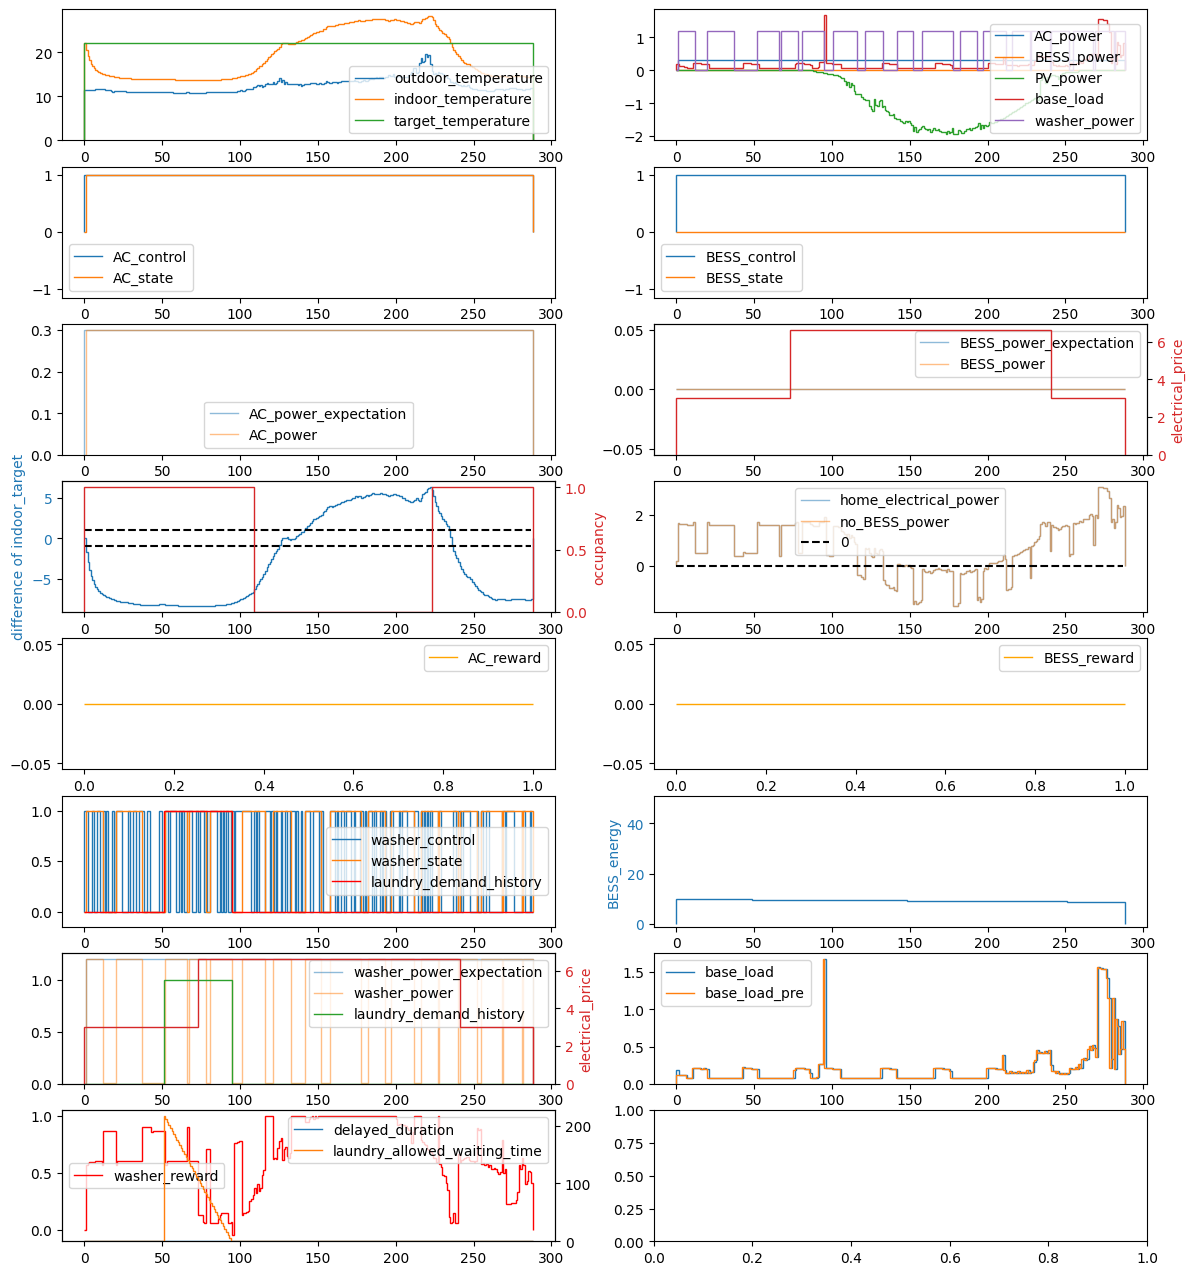

Episode Time: (1728, 2015)
KPIs:
electrical_consumption_sum: 13.54
electrical_cost_sum: 48.34
discomfort_proportion: 0.86
discomfort_cold_proportion: 0.86
discomfort_hot_proportion: 0.00
BESS_electrical_consumption_contribution: 13.54 / 22.41, 0.40
BESS_electrical_cost_contribution: 48.34 / 93.71, 0.48
AC_control: 288 / 288, 1.00
BESS_control: 288 / 288, 1.00
washer_control: 148 / 288, 0.51
AC_reward: 0.00
BESS_reward: 0.00
washer_reward: 193.36


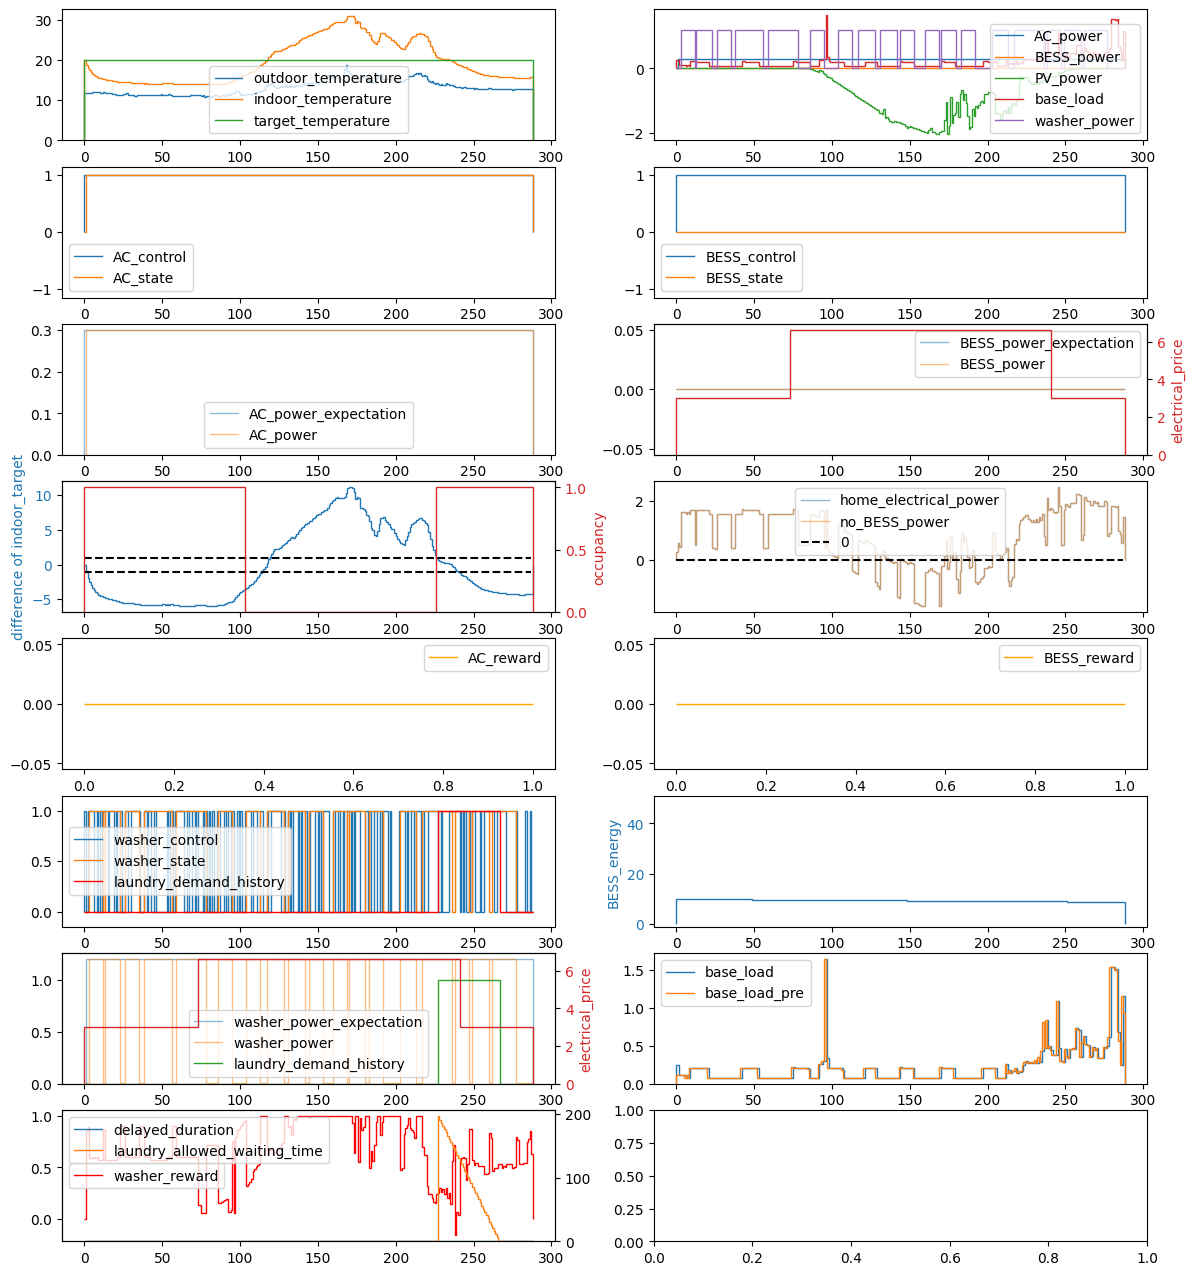

In [8]:
env = sa_env(**env_attr)
parallel_api_test(env, num_cycles=50)

renderer = Renderer(env=env.unwrapped, render_mode='episode')

for e in range(4):
    observation, infos = env.reset()
    terminations = {agent: False for agent in env.agents}
    truncations = {agent: False for agent in env.agents}
    while not any(terminations.values()) and not any(truncations.values()):
        actions = {agent: env.action_space(agent).sample() for agent in env.agents}
        observation, rewards, terminations, truncations, infos = env.step(actions)
        renderer.collect()
    renderer.render()
env.close()

# Testing vec env

## sa_env

In [9]:
env = sa_env(**env_attr)
env = ss.pettingzoo_env_to_vec_env_v1(env)

print(env.observation_space, env.action_space)
renderer = Renderer(env=env.unwrapped, render_mode='episode')

for e in range(4):
    observation, infos = env.reset()
    terminations = [False]
    truncations = [False]
    while not any(terminations) and not any(truncations):
        actions = env.action_space.sample()
        actions = np.array([actions])  # 转换为符合向量环境的输入
        observation, rewards, terminations, truncations, infos = env.step(actions)
    print(
        f'observation: {observation}, rewards: {rewards}, terminations: {terminations}, truncations: {truncations}, infos: {infos}')
    print(observation.shape, actions.shape)
# renderer.render()
env.close()

Make env: mode: train, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
Box(0.0, 1.0, (180,), float32) Box(-1.0, 1.0, (4,), float32)
observation: [[0.500005   0.5        0.5        0.500005   0.5        0.5
  0.500001   0.50005    0.500005   0.5        0.5        0.5
  0.5        0.50000054 0.50000006 0.5000001  0.5000005  0.5
  0.5001245  0.5        0.5        0.5001245  0.5        0.5
  0.500025   0.499996   0.500052   0.50001514 0.50000054 0.500005
  0.5        0.5000004  0.499996   0.500052   0.50001514 0.500005
  0.500005   0.5        0.5        0.500005   0.5        0.5
  0.500001   0.50005    0.500005   0.5        0.5        0.5
  0.5        0.50000054 0.50000006 0.5000001  0.5000005  0.5
  0.5001245  0.5        0.5        0.5001245  0.5        0.5
  0.500025   0.499996   0.500052   0.50001514 0.50000054 0.500005
  0.5        0.5000004  0.499996   0.500052   0.50001514 0.500005
  0.500005   0.5        0.5        0.500005   0.5        0.5
  0.500001   0.50005    0.50

## parallel env

In [10]:
# Testing Vec env
env = parallel_env(**env_attr)
agent_num = len(env.unwrapped.possible_agents)
env = ss.pettingzoo_env_to_vec_env_v1(env)
env_num = 8
env = ss.concat_vec_envs_v1(env, env_num, num_cpus=3, base_class="stable_baselines3")

print(env.observation_space, env.action_space)
renderer = Renderer(env=env.unwrapped, render_mode='episode')

for e in range(4):
    observation = env.reset()
    dones = [False]
    while not any(dones):
        actions = env.action_space.sample()
        actions = np.array([actions] * agent_num * env_num)  # 转换为符合向量环境的输入
        obs, rewards, dones, infos = env.step(actions)
    print(
        # f'observation: {observation}, '
        # f'rewards: {rewards}, '
        # f'terminations: {dones}, '
        # f'infos: {infos}'
    )
    print(observation.shape, actions.shape)
# renderer.render()
env.close()

Make env: mode: train, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
Box(-100000.0, 100000.0, (36,), float32) Box(-1.0, 1.0, (6,), float32)

(24, 36) (24, 6)

(24, 36) (24, 6)

(24, 36) (24, 6)

(24, 36) (24, 6)


# Testing sa_stack_env

In [11]:
from hem.HEM_v1 import sa_stack_env

sa_stack_env(**env_attr)

Make env: mode: train, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
